In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob
import os
from PIL import Image
from scipy.spatial import distance
from sklearn.cluster import KMeans
import pandas as pd
import random
import cv2
import time
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import contingency_matrix

In [2]:
def loadImages(testPath,gtPath):
    test_Images=[]
    gt_Images=[]
    flag=50
    for pic in glob.glob(testPath+"/*.jpg"):    
        img=Image.open(pic)
        img_test=np.asarray(img)
        if(img_test.shape[0]==321 and flag>0):
            flag-=1
            test_path=os.path.split(pic)
            fileName=test_path[1].split(".")[0]
            gt_path=gtPath+'/'+fileName+'.mat'
            gt_image=scipy.io.loadmat(gt_path)
            gt = np.empty(shape=(0,321,481))
            for i in range(5):
                gt = np.concatenate((gt, gt_image['groundTruth'][0][i][0][0][0].reshape((1,321,481)))) 
            test_Images.append(img_test)
            gt_Images.append(gt) 
    return test_Images,gt_Images    

In [3]:
def plot_Image_gt(test_image,gt_image,index):
    fig,axs = plt.subplots(1,6,figsize=(50,50))
    for i in range(6):
        if(i==0):
            axs[i].imshow(test_image[index])
            axs[i].axis('off') 
        else:
            axs[i].imshow(gt_image[index][i-1])
            axs[i].axis('off')  

In [4]:
def plot_segmenation_gt(test_image,gt_image,index):
    fig,axs = plt.subplots(1,6,figsize=(50,50))
    for i in range(6):
        if(i==0):
            axs[i].imshow(test_image)
            axs[i].axis('off') 
        else:
            axs[i].imshow(gt_image[index][i-1])
            axs[i].axis('off')  

In [5]:
def plot_Image(Image,x):
    fig,axs = plt.subplots(1,x,figsize=(50,50))
    for i in range(x):
        axs[i].imshow(Image[i])
        axs[i].axis('off') 

In [6]:
testPath='dataSet/BSR/BSDS500/data/images/test'
gtPath='dataSet/BSR/BSDS500/data/groundTruth/test'

In [7]:
testImages,gtImages=loadImages(testPath,gtPath)  

In [8]:
def KMEANS(data,k):
    centroids = data[np.random.choice(range(data.shape[0]),k,replace=False)]
    assignments=[]
    while(True):
        distances = np.zeros(shape=(data.shape[0],k))
        for i,cent in enumerate(centroids):
            dist = np.linalg.norm(data - cent,axis=1).reshape(data.shape[0])
            distances[:,i] = dist
        assignments = distances.argmin(axis=1)
        
        newCent = np.zeros(shape=(k,data.shape[1]))
        for i in range(k):
            mask = (assignments == i)
            newCent[i]=np.mean(data[mask],axis=0)
        if(np.all(newCent == centroids)):
            return assignments,centroids
            break
        else :
            centroids = newCent    
            
    return assignments,centroids

In [9]:
rgb=[[0,255,255],[255,255,0],[0,128,0],[0,0,128],[255,0,0]]
k=[3,5,7,9,11]
selectedImage=[0,10,20,30,40]

In [10]:
clust = list()
def imageSegmented(index):
    clust.clear()
    shape= testImages[index].shape[0:2]
    data1= testImages[index].reshape(shape[0]*shape[1],3)
    for j in range(len(k)):
        assignments,centroids= KMEANS(data1,k[j]) 
        clustred_data = np.array([centroids[i] for i in assignments])
        clustred_data =clustred_data .reshape(shape[0],shape[1],3)
        clustred_data = np.floor(clustred_data ).astype(int)
        clust.append(assignments)
        print("K=",k[j])
        plt.imshow(clustred_data )  
        plt.show()

In [24]:
def evaluation(cluster, groundtruth):
    clustering_labels = cluster
    gt_labels = groundtruth.flatten()
    contingency_mat = contingency_matrix (gt_labels, clustering_labels)
    contingency_T = contingency_mat.T
    #print(contingency_mat,contingency_mat.shape)
    precision = np.zeros((contingency_T.shape[0],1))
    recall = np.zeros((contingency_T.shape[0],1))
    ##rows represent predicted clusters with kmeans
    ## coloumns represents ground truth classes
    for i in range(contingency_T.shape[0]):
        index_max = np.argmax(contingency_T[i]) ## max index
        precision[i] = contingency_T[i][index_max]/np.sum(contingency_T[i])
        recall[i] = contingency_T[i][index_max]/np.sum(contingency_T[:,index_max])

    fscore = (2*precision*recall) / (precision + recall)
    fscore_total = np.mean(fscore)
    
    count_cluster = np.sum(contingency_T,axis =1)

    count_entropy = np.where(np.copy(contingency_T) == 0, 1, np.copy(contingency_T)) ## where log(1) = 0 && log(0) = -infinty
    entropy_mat = np.zeros((count_entropy.shape[0],1))
    
    for i in range(count_entropy.shape[0]):
        entropy_mat[i] = np.sum(-contingency_T[i]*np.log10(count_entropy[i]/np.sum(contingency_T[i]))) / np.sum(contingency_T[i]) ## H(T|Ci)
        entropy_mat[i] = count_cluster[i] * entropy_mat[i] ## segma i = 1 till number of clusters : counter per cluster * H(T|Ci)
   
    entropy = np.sum(entropy_mat)/ np.sum(count_cluster) ## final conditional entropy
    
    return fscore_total,entropy

In [25]:
def Fscore_Entropy(index):
    imageSegmented(index)
    fscore = 0
    entropy = 0
    fscore_list = list()
    entropy_list = list()
    for i in range(len(clust)):
        fscore = 0
        entropy = 0
        for j in range(len(clust)):
            f_score,ent = evaluation(clust[i],gtImages[8][j])
            fscore += f_score
            entropy += ent
        fscore_list.append(fscore/5)
        entropy_list.append(entropy/5)
    
    for i in range(len(fscore_list)):
        print("Average F-Score Of Segmented Image Number "+str(index) +" with k = " +str(k[i]) +" is = "+str(fscore_list[i]))
    for i in range(len(entropy_list)):
        print("Average Conditional Entropy Of Segmented Image Number "+str(index) +" with k = " +str(k[i]) +" is = "+str(entropy_list[i]))

**Kmeans for Selected Image with k=3,5,7,9,11**

K= 3


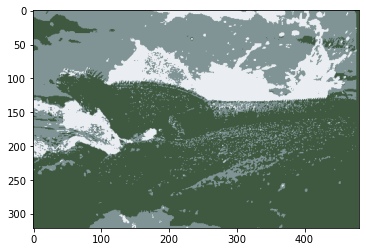

K= 5


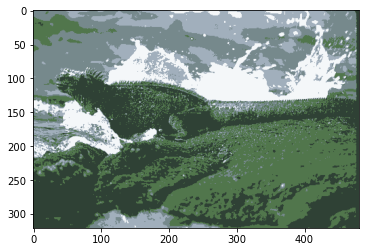

K= 7


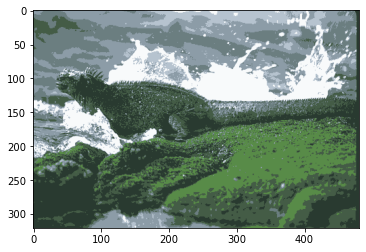

K= 9


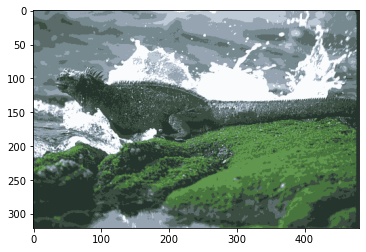

K= 11


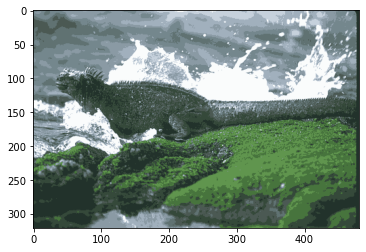

Average F-Score Of Segmented Image Number 8 with k = 3 is = 0.709939329564707
Average F-Score Of Segmented Image Number 8 with k = 5 is = 0.5572048945199042
Average F-Score Of Segmented Image Number 8 with k = 7 is = 0.4563190727854911
Average F-Score Of Segmented Image Number 8 with k = 9 is = 0.3792427516168508
Average F-Score Of Segmented Image Number 8 with k = 11 is = 0.34022753998350364
Average Conditional Entropy Of Segmented Image Number 8 with k = 3 is = 0.47269231540792134
Average Conditional Entropy Of Segmented Image Number 8 with k = 5 is = 0.43392261148744427
Average Conditional Entropy Of Segmented Image Number 8 with k = 7 is = 0.4007647668574239
Average Conditional Entropy Of Segmented Image Number 8 with k = 9 is = 0.37797403732440343
Average Conditional Entropy Of Segmented Image Number 8 with k = 11 is = 0.37347047101061887


In [26]:
Fscore_Entropy(8)

**Original Images VS GroundTruth**

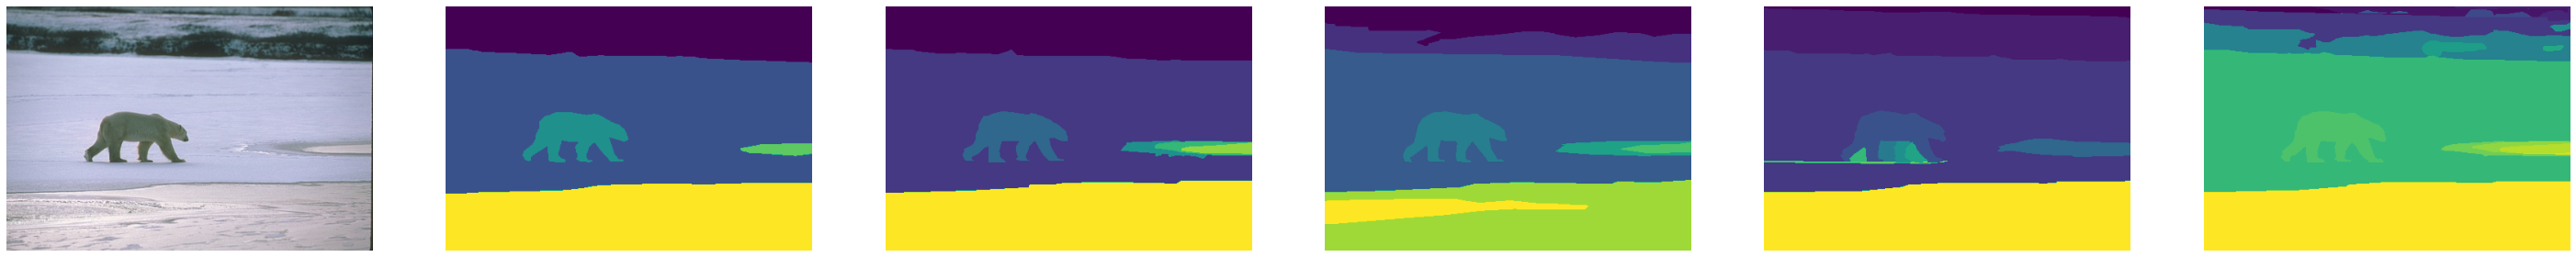

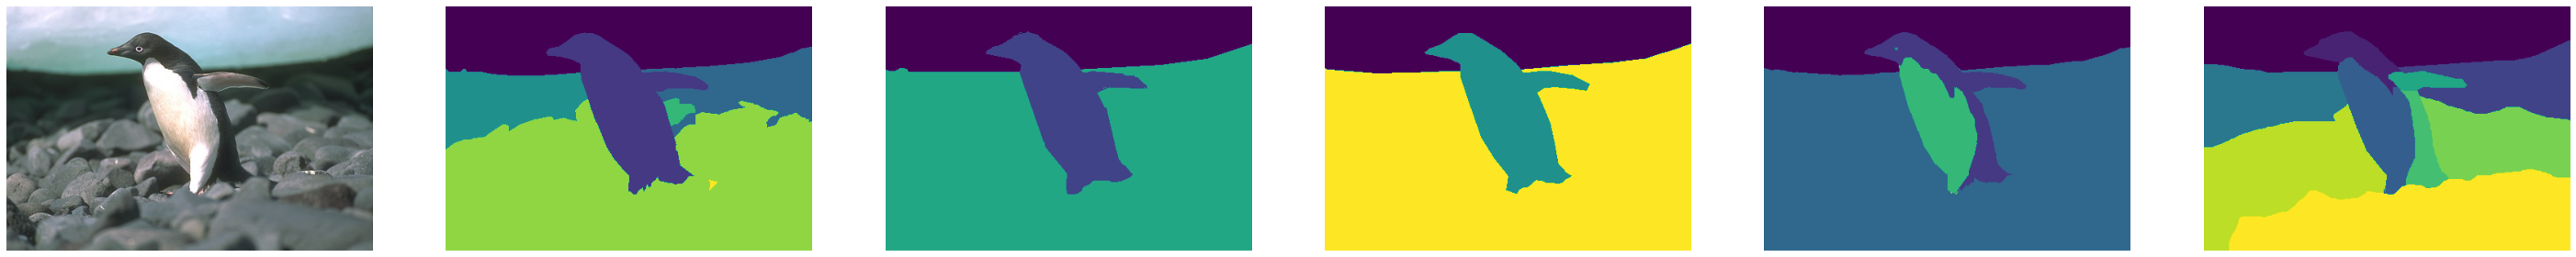

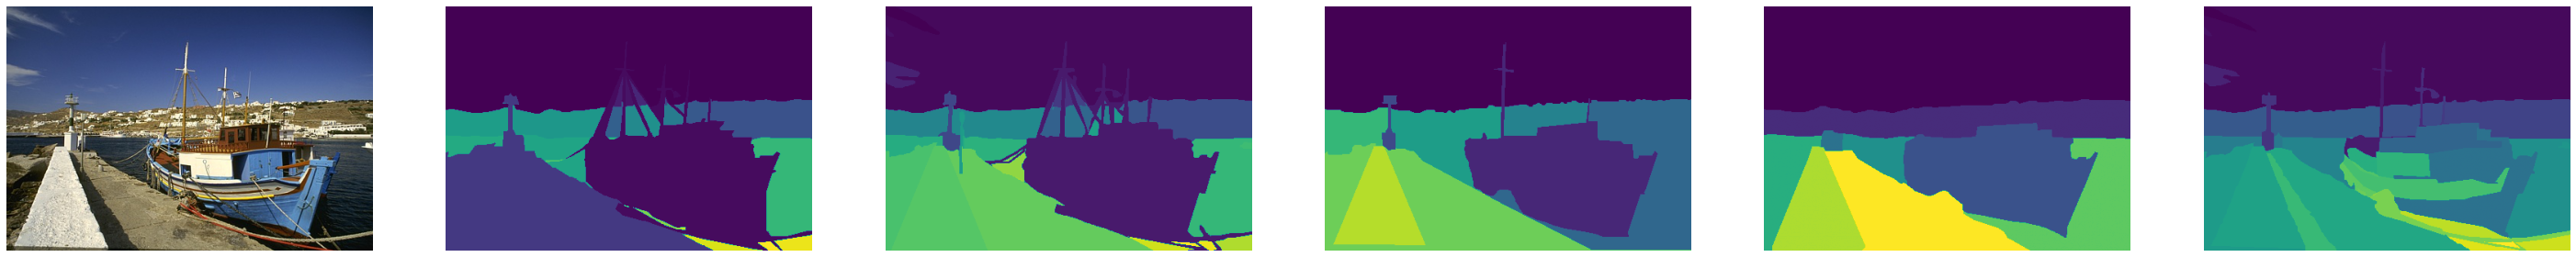

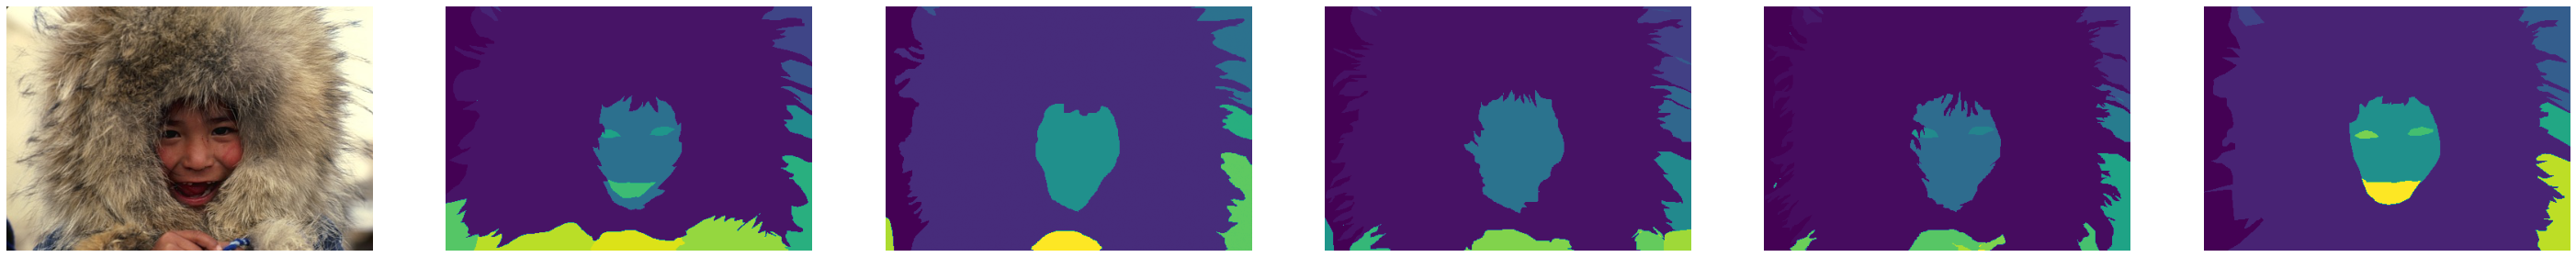

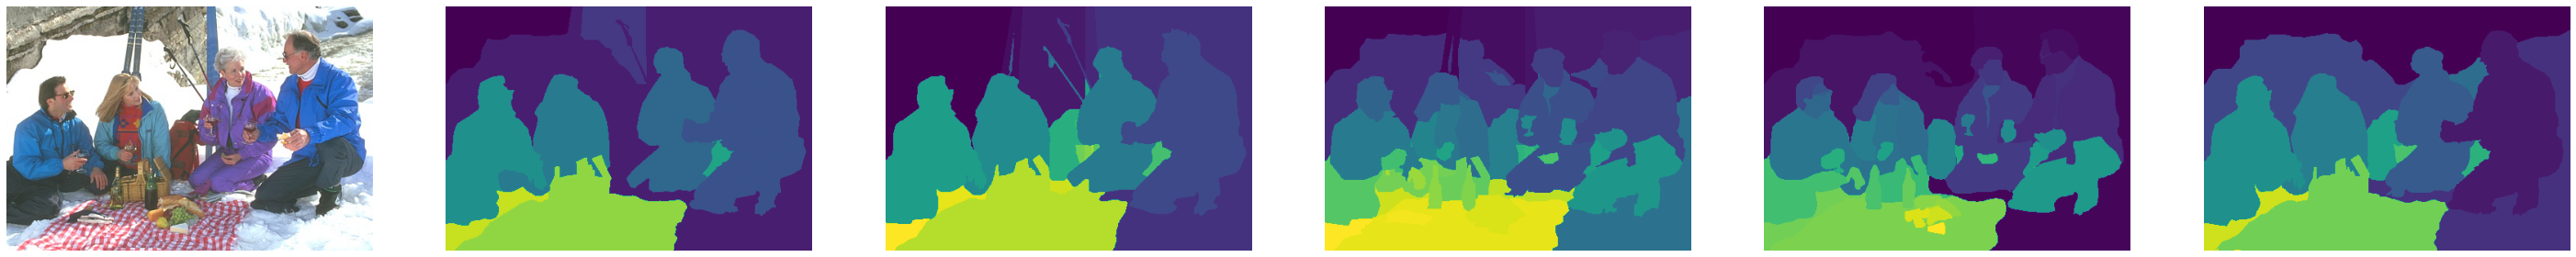

In [14]:
for i in range(len(selectedImage)):
    plot_Image_gt(testImages,gtImages,selectedImage[i])     

**Kmeans VS GroundTruth AT K=5**

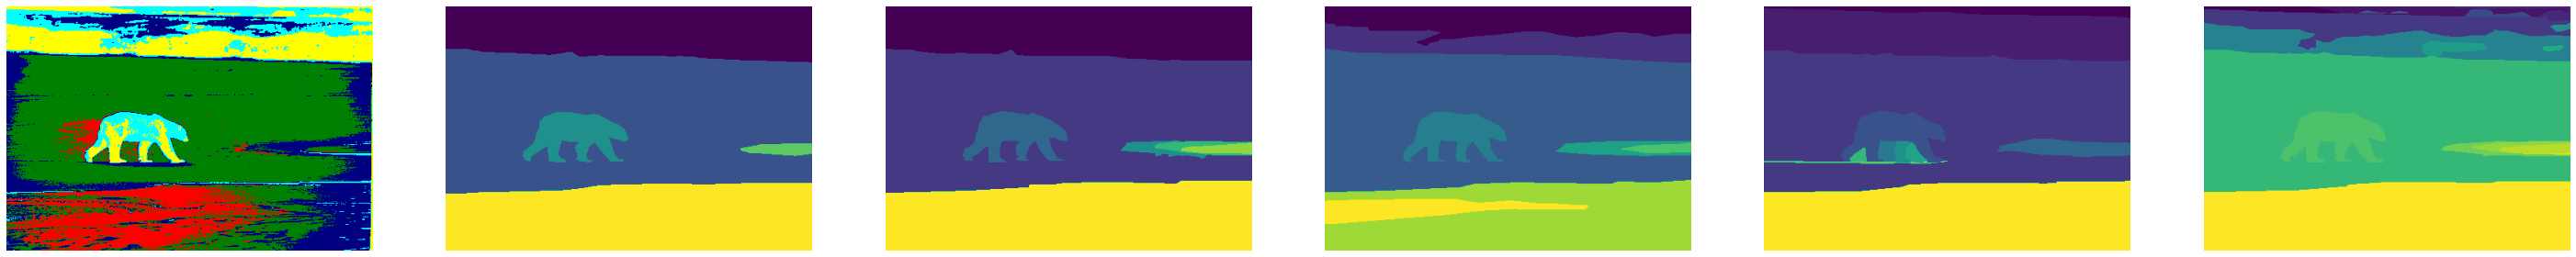

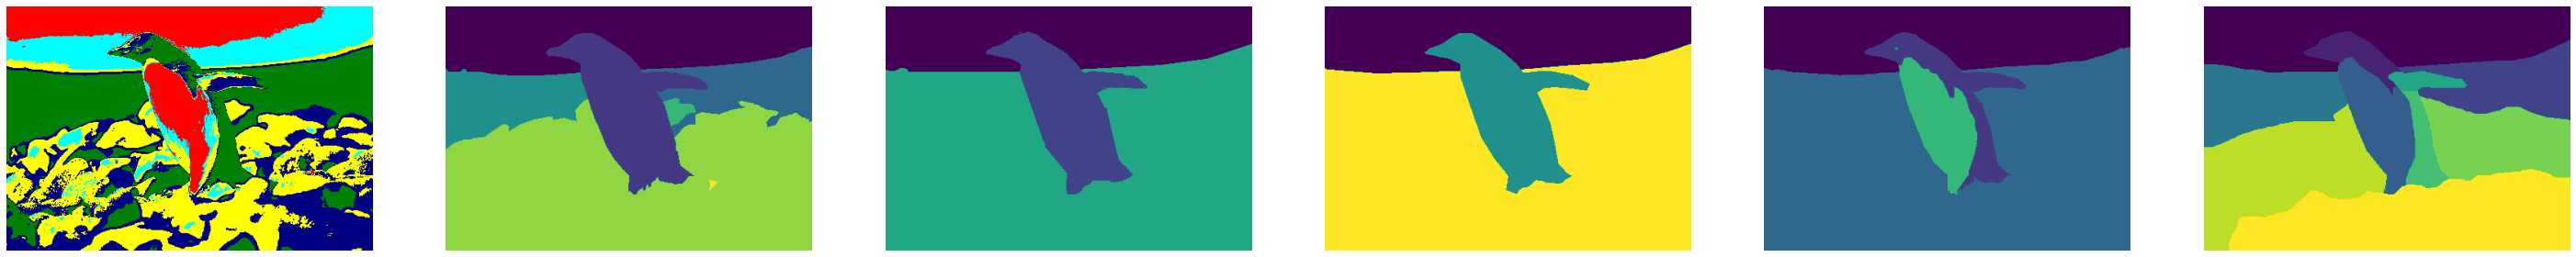

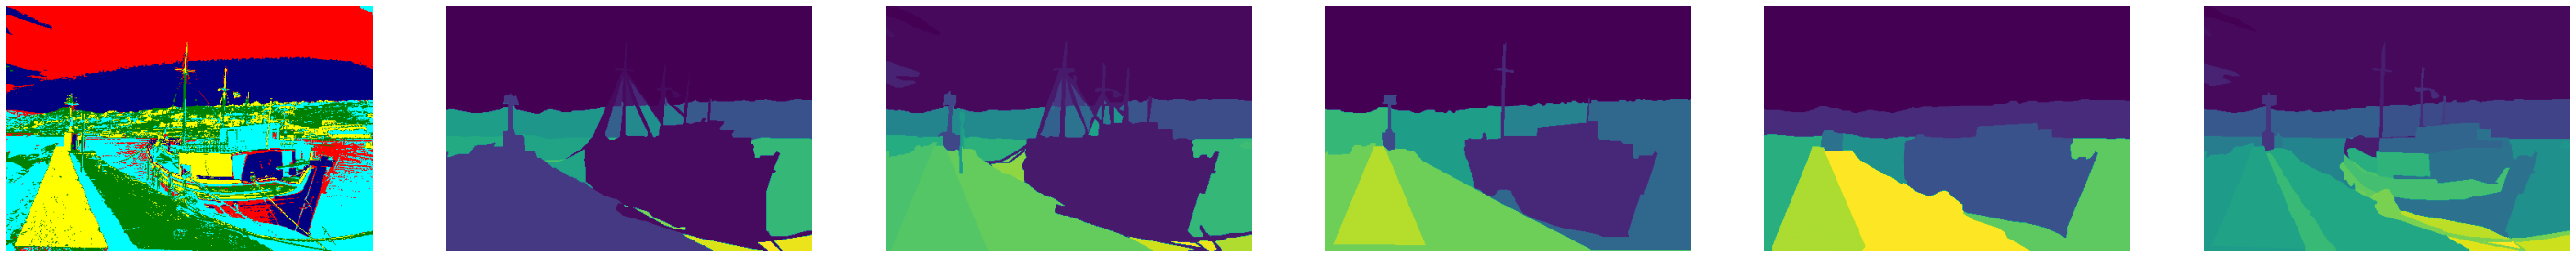

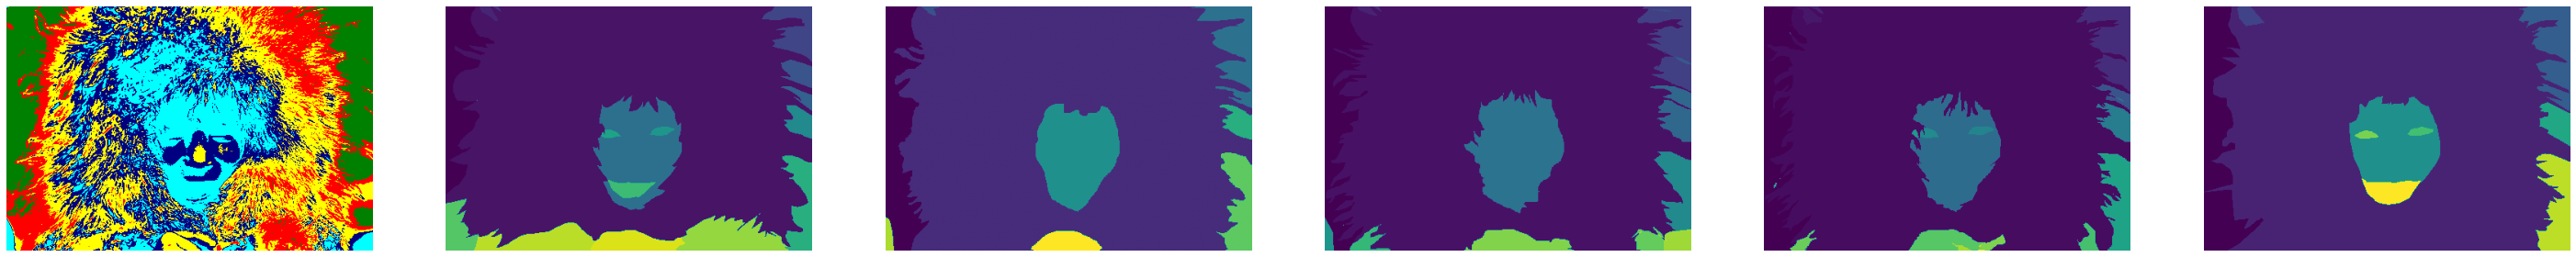

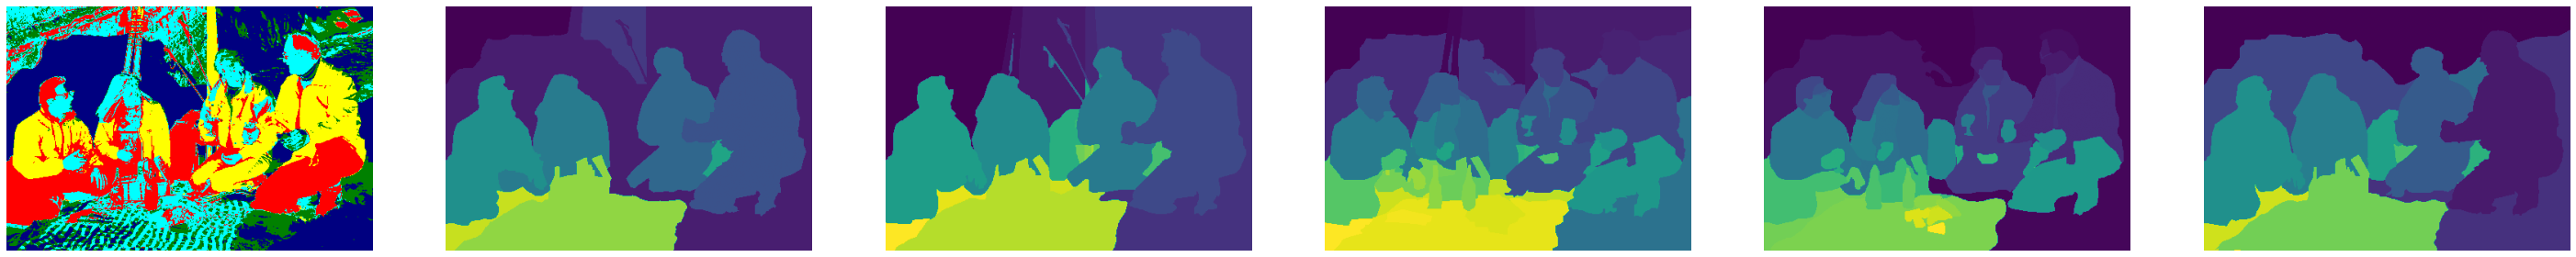

In [15]:
clusterd=[]
for i in range(len(selectedImage)):
    shape= testImages[selectedImage[i]].shape[0:2]
    data1= testImages[selectedImage[i]].reshape(shape[0]*shape[1],3)
    assignments,centroids= KMEANS(data1,5) 
#     clustred_data = np.array([centroids[i] for i in assignments])
    clustred_data = np.array([rgb[i] for i in assignments])
    clustred_data =clustred_data .reshape(shape[0],shape[1],3)
    clustred_data = np.floor(clustred_data ).astype(int)
    clusterd.append(clustred_data)
    plot_segmenation_gt(clustred_data,gtImages,selectedImage[i])

In [16]:
def normalization(Y):
    for i in range(len(Y)):
        Y[i]=Y[i]/np.linalg.norm(Y[i])
    return Y

In [17]:
def sol(k,cluster):
    delta=np.diag(np.sum(k,axis=1))
    Lmatrix=delta-k
    deltainverse=np.linalg.inv(delta)
    B=deltainverse.dot(Lmatrix)
    eigenValue,eigenVector=np.linalg.eigh(B) 
    basis=eigenVector[:,0:cluster]
    return normalization(basis)

In [18]:
def K_ways(data,KNN,cluster):
        k=kneighbors_graph(data,KNN,mode='connectivity',include_self=False).toarray()
        normalizedBasis=sol(k,cluster)
        assignments,centroids= KMEANS(normalizedBasis,cluster) 
        return assignments,centroids

In [19]:
NC=[]
for i in range(len(selectedImage)-2):
    scale_percent = 25# percent of original size
    image=testImages[selectedImage[i]]
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized= cv2.resize(image, dim, interpolation = cv2.INTER_AREA) 
    shape= resized.shape[0:2]
    data= resized.reshape(shape[0]*shape[1],3)
    assignments,centroids=K_ways(data,5,5)
    clustred_data = np.array([rgb[i] for i in assignments])
    clustred_data =clustred_data.reshape(shape[0],shape[1],3)
    clustred_data = np.floor(clustred_data).astype(int)
    NC.append(clustred_data)

 **5-NN VS GroundTruth K=5**

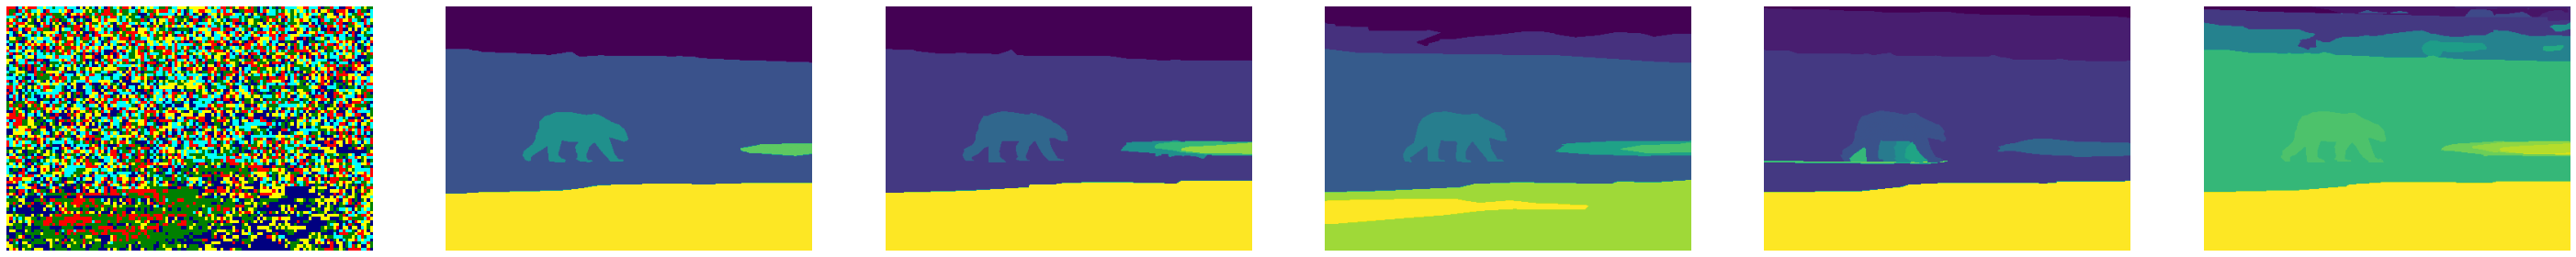

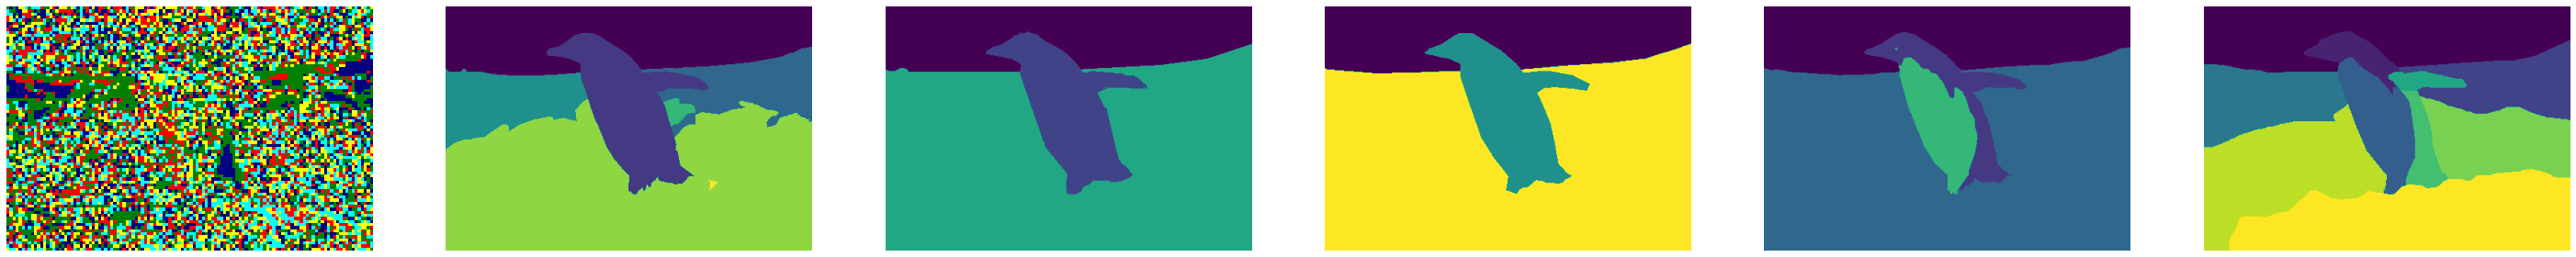

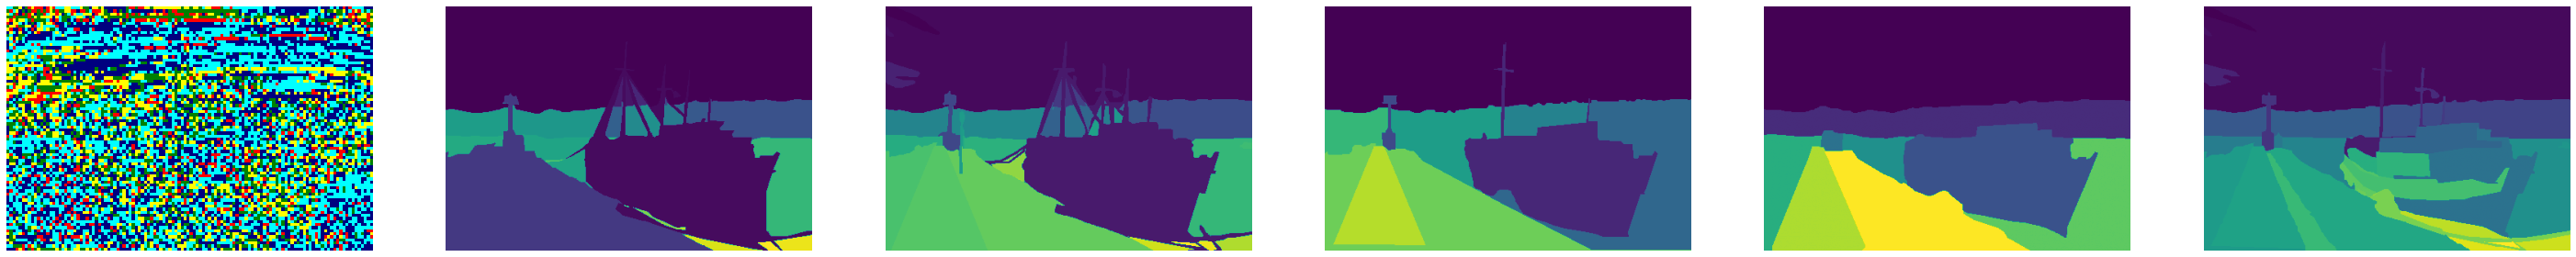

In [20]:
for i in range(len(NC)):
    plot_segmenation_gt(NC[i],gtImages,selectedImage[i])

 **5-NN VS Kmeans K=5**

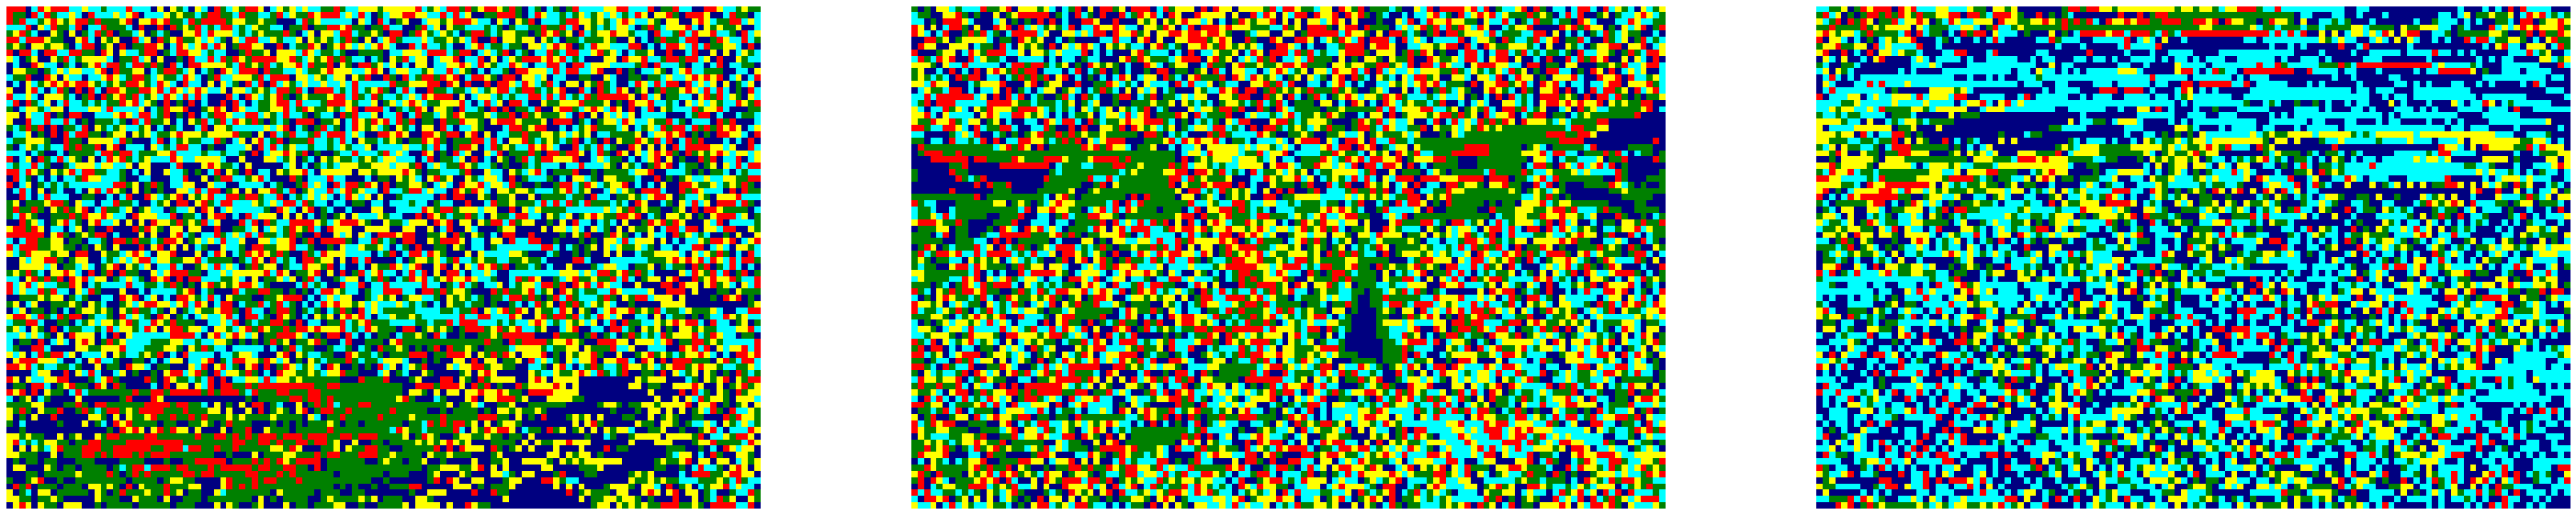

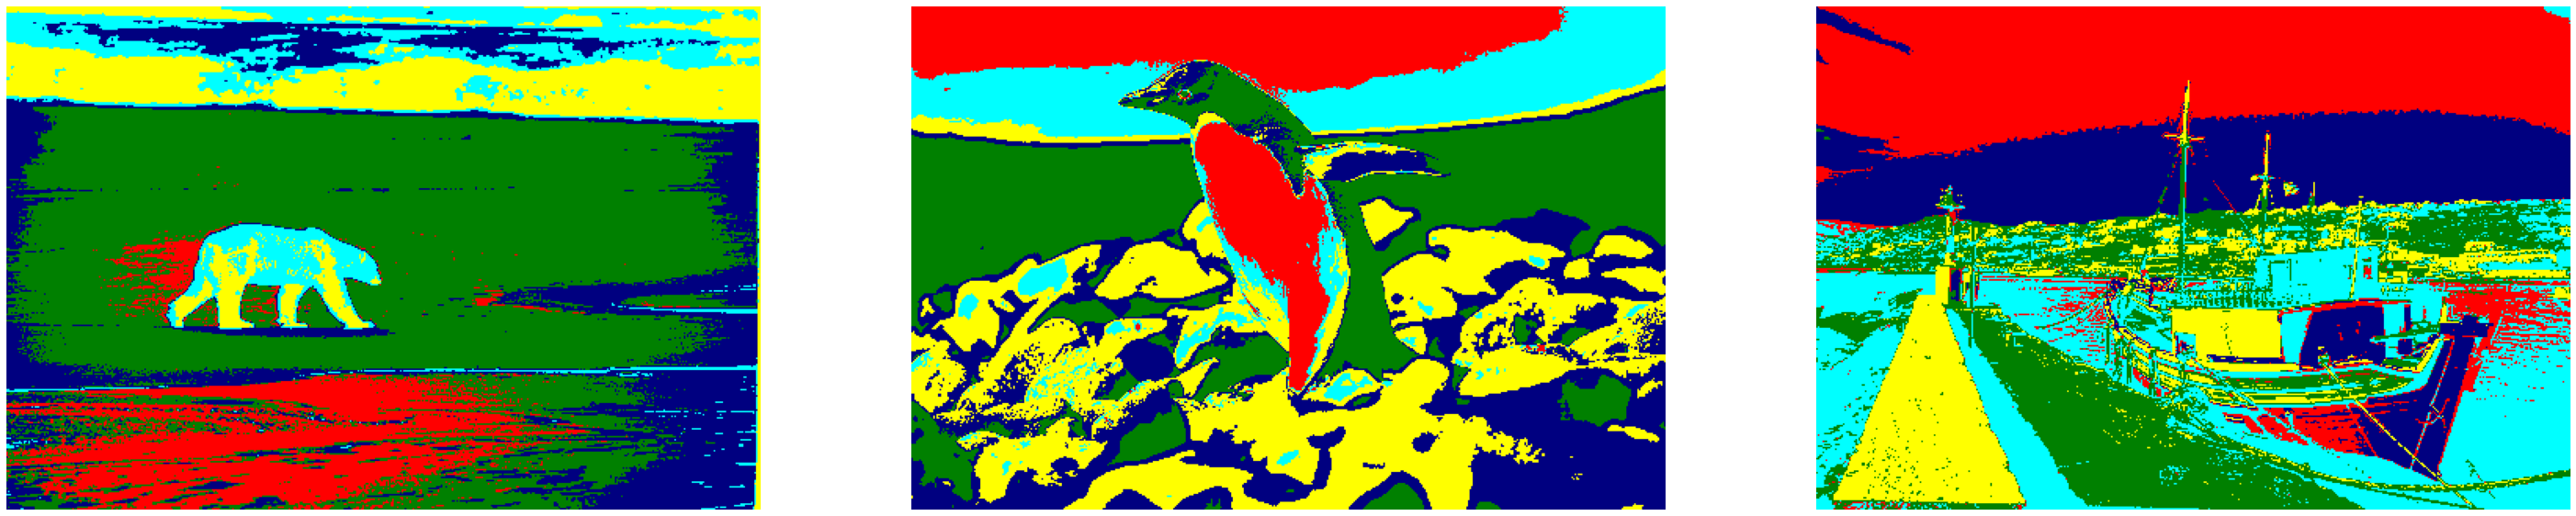

In [21]:
plot_Image(NC,3)
plot_Image(clusterd,3)